In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("../utils")
import toolbox_ML as tb
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

from scipy.stats import ttest_ind

### 1. Obtención de los datos

In [150]:
df=pd.read_csv('../data_sample/ai4i2020.csv')


### 2. Entendiendo los datos y el problema

#### 2.1 Datos

Los datos que tenemos son distintas mediciones de obtenidas de una máquina entre las cuales están reesgistros tomados antes de que la máquina  falle, Los valores de medición que nos propociona son:
- Type (tipo de producto.)
- Air temperature
- Process temperatura
- Rotationa speed
- Torque
- Tool Wear

veremos que hay variables que dada su naturaleza tendremos que tratar, y crearemos nuevas a partir de las que tenemos.

Despues tenemos la variable Machine Failure que indica si la máquina ha fallado 

Y por último tenemos los diferentes tipos de Fallos.

- TWF: Fallo por desgaste de la herramienta.
- HDF: Fallo por disipación de calor.
- PWF: Fallo de potencia
- OSF: Fallo por sobrecarga si el prodçucto se desgasta
- RNF: Fallo aleatorio, sin especificar el origen

En cuanto a los tipos de fallos y si la máquina falla hay un desajuste que es necesario resolver.

#### 2.2 Problema

El problema que debemos resolver es hacer un modelo que prediga cuando una máquina va a fallar, para que esta entre en un modo mantenimiento o pausa y no genere se llegue a estropear. es decir, poner remedio antes de que se cause el problema. También vamos a clasificar ese fallo para que sea más fácil su tratamiento.


In [151]:
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0


##### Cambio de nombre de variables
Para que sea más cómodo trabar he cambiado el nombre de algunas variables.

In [152]:
# Renombrar Columnas para que sea más cómodo trabajar con ellas
df.rename(columns = {'Product ID':'Product_ID',
                    'Air temperature [K]':'Air_temperature',
                     'Process temperature [K]':'Process_temperature',
                     'Rotational speed [rpm]':'Rotational_speed',
                     'Torque [Nm]':'Torque',
                     'Tool wear [min]':'Tool_wear',
                     'Machine failure':'Machine_failure',},
          inplace = True)

#### 3-Primera exploración de datos
En la primera exploración de datos vemos que tenemos 10000 registros y 13 registros.

No contiene valores nulos.

Los fallos están representados con 0 i 1, 

En cuanto a los valores númericos los analizaremos más adelante para ver su distibución.

En los siguientes pasos me he centrado en analizar y ajustar las variables  de fallos.

In [153]:
df.head()

,UDI,Product_ID,Type,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Machine_failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [141]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [157]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UDI,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air_temperature,10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process_temperature,10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque,10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool_wear,10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine_failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


##### 3.1 Ajuste de la variables de registro de fallos
Primero de todo he comprobado que cuando una máquina falla esta registrado tanto en el campo "Machine_failure" como su tipo de fallo y a la inversa ( si hay registrado un tipo de fallo tiene que estar registrado en "Machine_failure"), pero he visto que hay un desajuste.

También he visto que una máquina puede tener 2 o más tipos de fallos a la vez. por lo que he creado una nueva variable con los diferentes tipos de fallos

En las siguientes lineas de código queda registrado el paso a paso.

In [161]:
#Hay un desajuste entre las columnas de fallos y la columna Machine_failure
columnas_fallos=['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

print(f'Suma total de todas las columnas de fallos: {df[columnas_fallos].sum().sum()}')
print(f"Suma total de la columna Machine_failure: {df.Machine_failure.sum()}")

Suma total de todas las columnas de fallos: 373
Suma total de la columna Machine_failure: 339


In [162]:
#creamos una columna auxiliar para sumar los fallos
df['Total_Failures'] = df[columnas_fallos].sum(axis=1)


In [163]:
#Si hay fallo en la máquina y no hay fallos en los tipos de fallos, 
# entonces se considera que hay un fallo de tipo RNF (fallo Aleatorio)
df.loc[(df['Machine_failure'] == 1) & 
       (df[columnas_fallos].sum(axis=1) == 0), 'RNF'] = 1


In [164]:
# si las columnas tipos de fallo tienen un valor de 1, 
# entonces se considera que hay un fallo en la máquina
for i in columnas_fallos:
    df.loc[df[i] == 1, 'Machine_failure'] = 1
df.Machine_failure.sum()

np.int64(357)

In [165]:
#Si hay mas de un tipo fallo en la máquina, entonces se considera que hay un fallo múltiple
df['Multiple_Failures'] = df['Total_Failures'] > 1


In [166]:
#Los fallos múltiples no pueden tener fallos individuales
df.loc[df['Multiple_Failures'], columnas_fallos] = 0

In [ ]:
#volvemos a comparar La columa Machine_failure con la suma de las columnas de fallos y ahora si, tenemos los mismo valores 
print(f'Suma total de todas las columnas de fallos: {df[columnas_fallos + ["Multiple_Failures"]].sum().sum()}')
print(f"Suma total de la columna Machine_failure: {df.Machine_failure.sum()}")

Suma total de todas las columnas de fallos: 357
Suma total de la columna Machine_failure: 357


#### 3.2 Analisis de las variables de fallos
En los siguientes graficos muestro la distribución de la Variable Machine_ failure ( si una máquina falla o no)Y la distrubución de los diferentes fallos. 

Dados estos datos he tomado la decisión de crear dos modelos. 

- El primero predice si hay un fallo o no, 
- El segundo clasifica el tipo de error.

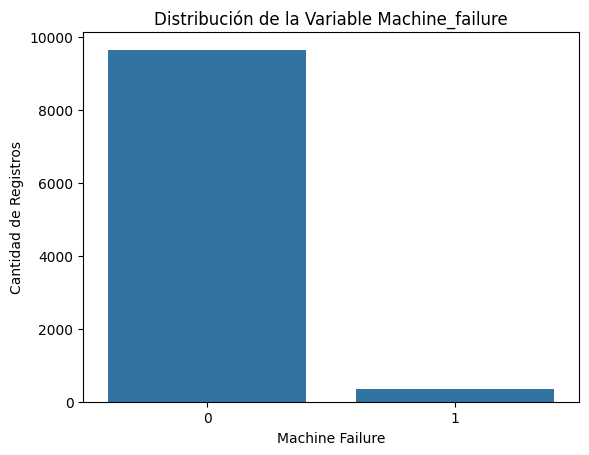

In [169]:
sns.countplot(x=df['Machine_failure'])
plt.title('Distribución de la Variable Machine_failure')
plt.xlabel('Machine Failure')
plt.ylabel('Cantidad de Registros')
plt.show()

In [ ]:
#Dado que hay una columan de error de pontencia agregamos una nuevacolumna con el valor de la pontencia.
#Esto facilitará la clasficicacion de este error.
df['Power'] = df[['Rotational_speed', 'Torque']].product(axis=1)

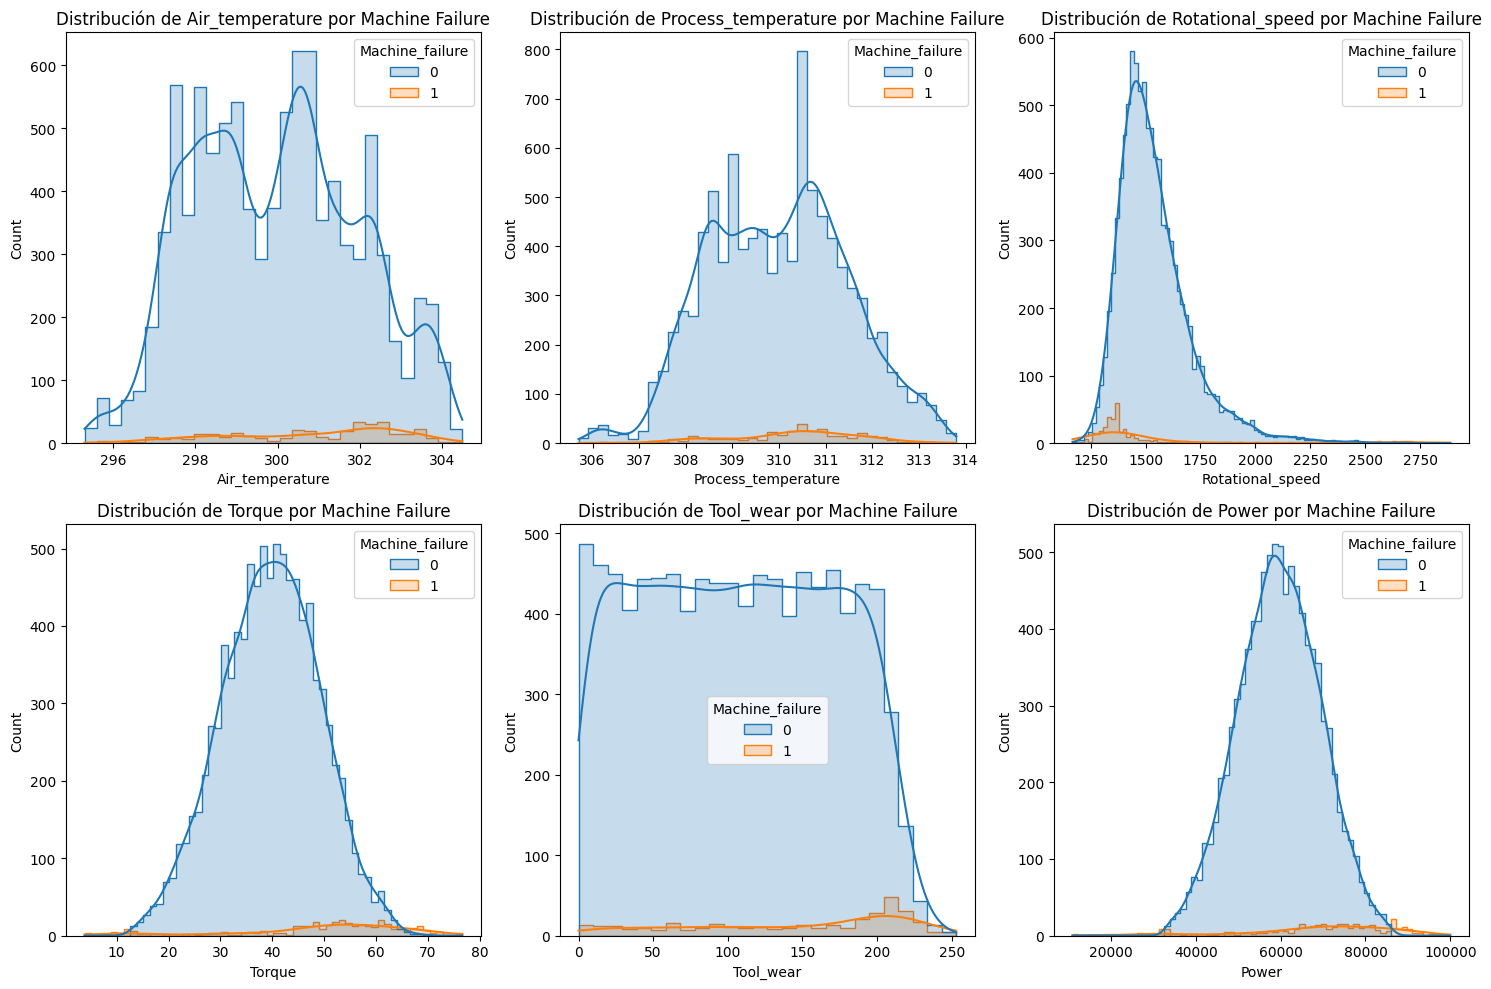

In [18]:
# Histogramas
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, hue='Machine_failure', element='step', kde=True)
    plt.title(f'Distribución de {col} por Machine Failure')
plt.tight_layout()
plt.show()

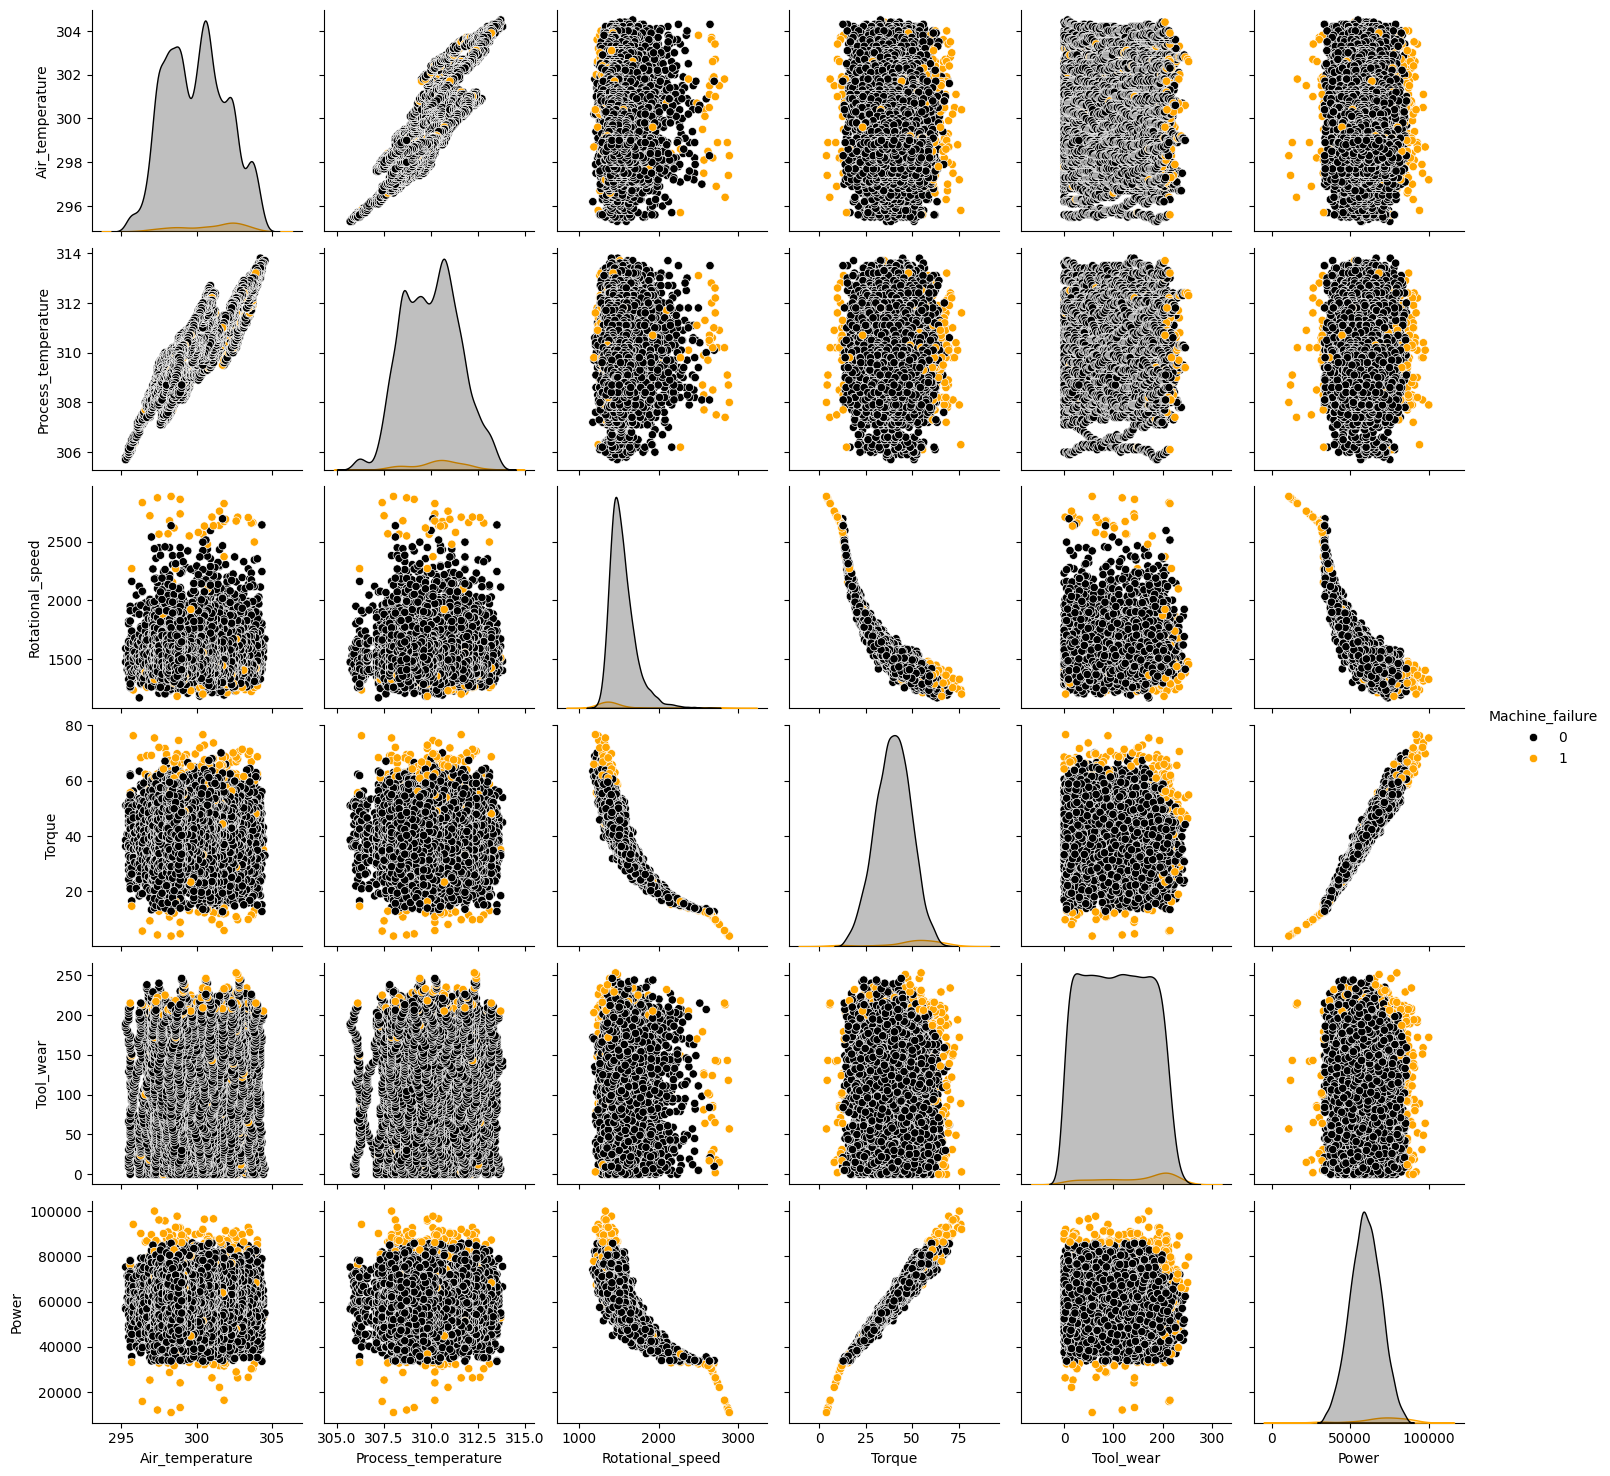

In [13]:
# List of numerical features to be analyzed, based on the dataset description 
num_cols = [
    'Air_temperature', 
    'Process_temperature', 
    'Rotational_speed', 
    'Torque', 
    'Tool_wear',
    'Power'
]

# Generating pairplot
sns.pairplot(df[num_cols + ['Machine_failure']], hue='Machine_failure', palette={0: 'black', 1: 'orange'})
plt.show()

In [14]:
X = df[num_cols]
X.head()

,Air_temperature,Process_temperature,Rotational_speed,Torque,Tool_wear,Power
0,298.1,308.6,1551,42.8,0,66382.8
1,298.2,308.7,1408,46.3,3,65190.4
2,298.1,308.5,1498,49.4,5,74001.2
3,298.2,308.6,1433,39.5,7,56603.5
4,298.2,308.7,1408,40.0,9,56320.0


In [15]:
# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [16]:
"""
from sklearn.feature_selection import SelectKBest, f_classif

'''
f_classif realiza un test ANOVA
a técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,
constituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre
la media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de
dos o más grupos.
'''
selector = SelectKBest(f_classif, k=6)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
X_train_kbest
"""

"\nfrom sklearn.feature_selection import SelectKBest, f_classif\n\n'''\nf_classif realiza un test ANOVA\na técnica de análisis de varianza (ANOVA) también conocida como análisis factorial y desarrollada por Fisher en 1930,\nconstituye la herramienta básica para el estudio del efecto de uno o más factores (cada uno con dos o más niveles) sobre\nla media de una variable continua. Es por lo tanto el test estadístico a emplear cuando se desea comparar las medias de\ndos o más grupos.\n'''\nselector = SelectKBest(f_classif, k=6)\nx_data_kbest = selector.fit_transform(X_train, y_train)\nX_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())\nX_train_kbest\n"

In [17]:
# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [18]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19286 entries, 0 to 19285
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air_temperature      19286 non-null  float64
 1   Process_temperature  19286 non-null  float64
 2   Rotational_speed     19286 non-null  int64  
 3   Torque               19286 non-null  float64
 4   Tool_wear            19286 non-null  int64  
 5   Power                19286 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 904.2 KB


In [19]:
# División en train y test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)


In [23]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Definir el modelo base
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Configurar la validación cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluar con Cross-Validation
cv_scores = cross_val_score(rf, X_resampled, y_resampled, cv=cv, scoring='f1')
print(f'F1-Score promedio en Cross-Validation: {np.mean(cv_scores):.4f}')

# Definir hiperparámetros a buscar
param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_resampled, y_resampled)

# Mejor modelo encontrado
best_rf = grid_search.best_estimator_


F1-Score promedio en Cross-Validation: 0.9606
Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [24]:
best_rf

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=50,
                       random_state=42)

Carga de datos y primer analisis


In [122]:
df=pd.read_csv('../data_sample/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [131]:
# Eliminamos las columnas que no aportan información relevante para el modelo
df.drop(columns=['Product_ID','UDI','Total_Failures'], axis=1, inplace=True)

In [ ]:
#Eliminamos las columnas de fallos ya que hemos incluido todos los fallos en la columna Machine_failure
#df.drop(columns=columnas_fallos, axis=1, inplace=True)

In [93]:
# Codificar 'Type'
df['Type'] = df['Type'].map({'L': 1, 'M': 2, 'H': 3})

El dataset está altamente desbalanceado y después de estudiar bien los datos he optado por hacerlo en dos etapas utilizando dos modelos
- El primero  detecta el error(si hay error o no). para ello solo tendré en cuenta la columna "Machine_failure"
- El segundo, en caso de detectar el error nos clasificará el tipo de error, para ello utilizaré los tipos de error.


In [132]:
# Separar dataset en dos para el modelo en dos etapas
primario_df = df.copy()
secundario_df = df[df['Machine_failure'] == 1].copy()


In [135]:
primario_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Air_temperature,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process_temperature,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational_speed,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool_wear,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0
Machine_failure,10000.0,0.03570,0.185550,0.0,0.0,0.0,0.0,1.0
TWF,10000.0,0.00420,0.064674,0.0,0.0,0.0,0.0,1.0
HDF,10000.0,0.01060,0.102414,0.0,0.0,0.0,0.0,1.0
PWF,10000.0,0.00800,0.089089,0.0,0.0,0.0,0.0,1.0
OSF,10000.0,0.00780,0.087977,0.0,0.0,0.0,0.0,1.0


In [136]:
secundario_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Air_temperature,357.0,300.880392,2.054225,295.6,299.1,301.6,302.5,304.4
Process_temperature,357.0,310.313725,1.372465,306.1,309.5,310.5,311.2,313.7
Rotational_speed,357.0,1496.131653,375.869908,1181.0,1329.0,1366.0,1439.0,2886.0
Torque,357.0,49.833053,16.196335,3.8,45.3,53.2,61.0,76.6
Tool_wear,357.0,142.577031,72.650679,0.0,84.0,163.0,207.0,253.0
Machine_failure,357.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
TWF,357.0,0.117647,0.322642,0.0,0.0,0.0,0.0,1.0
HDF,357.0,0.296919,0.457542,0.0,0.0,0.0,1.0,1.0
PWF,357.0,0.224090,0.417567,0.0,0.0,0.0,0.0,1.0
OSF,357.0,0.218487,0.413800,0.0,0.0,0.0,0.0,1.0


Analizamos e

In [133]:
# Seleccionar variables numéricas
num_cols = [
    'Air_temperature', 
    'Process_temperature', 
    'Rotational_speed', 
    'Torque', 
    'Tool_wear',
    'Power'
]

In [96]:
# Separar features y target para el primer modelo (detectar si la máquina falla o no)
X_primario = primario_df.drop(columns=['Machine_failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF','Multiple_Failures'])
y_primario = primario_df['Machine_failure']

In [97]:
# Aplicar SMOTE para balancear el dataset
smote = SMOTE(random_state=42)
X_primario_resampled, y_primario_resampled = smote.fit_resample(X_primario, y_primario)

In [98]:
# División en train y test
X_train_primario, X_test_primario, y_train_primario, y_test_primario = train_test_split(
    X_primario_resampled, y_primario_resampled, test_size=0.2, stratify=y_primario_resampled, random_state=42)

In [110]:
# Entrenar primer modelo (detección de fallo)
rf_primario = RandomForestClassifier(n_estimators=5, class_weight='balanced', random_state=42)
rf_primario.fit(X_train_primario, y_train_primario)
y_pred_primario = rf_primario.predict(X_test_primario)

In [111]:
print("Evaluación del primer modelo (Detección de fallo):")
print(confusion_matrix(y_test_primario, y_pred_primario))
print(classification_report(y_test_primario, y_pred_primario))

Evaluación del primer modelo (Detección de fallo):
[[1824  105]
 [  59 1870]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1929
           1       0.95      0.97      0.96      1929

    accuracy                           0.96      3858
   macro avg       0.96      0.96      0.96      3858
weighted avg       0.96      0.96      0.96      3858



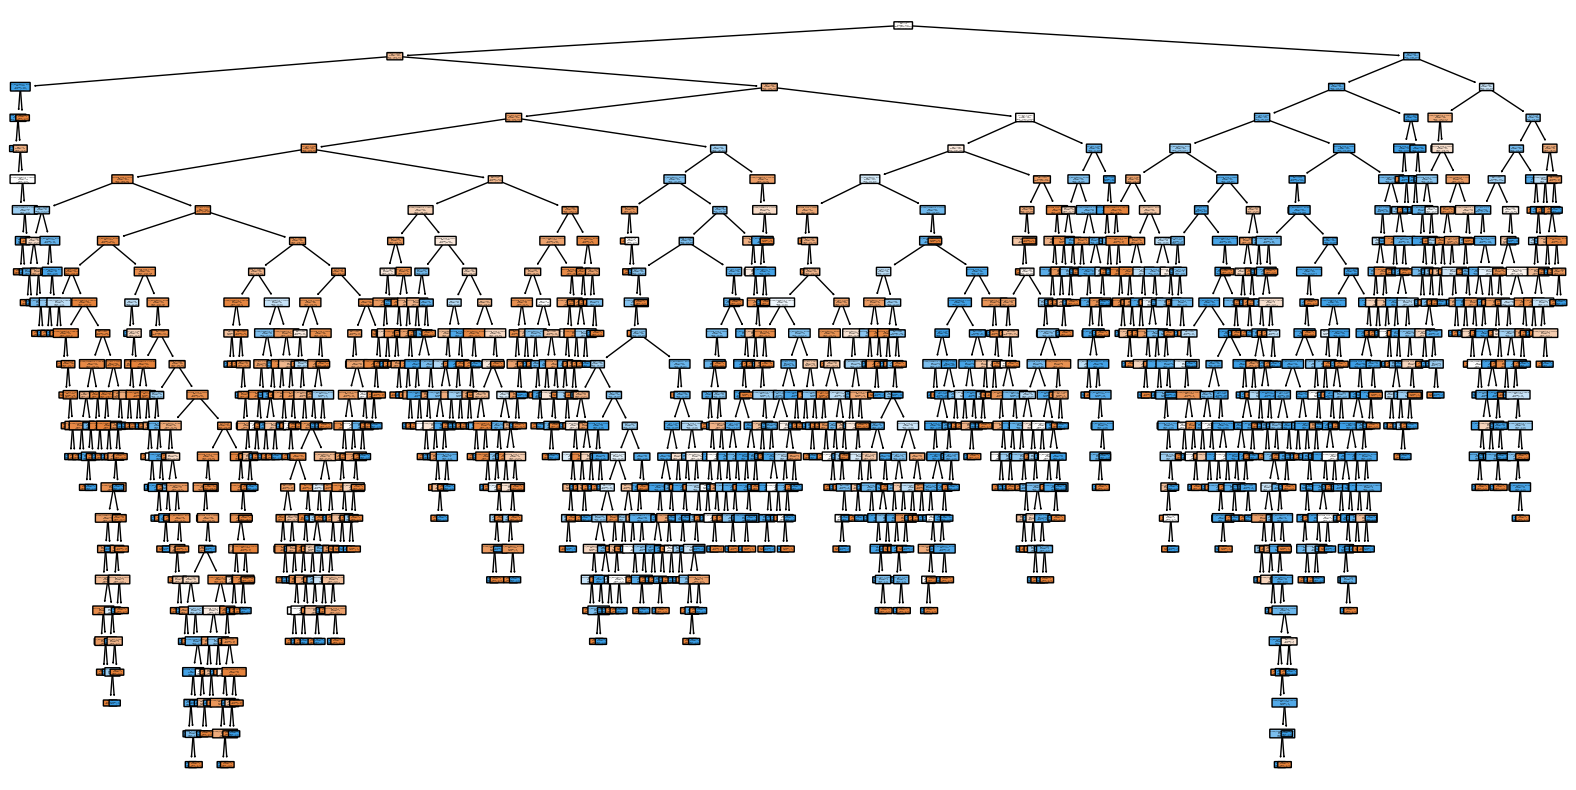

In [112]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Obtener un solo árbol del Random Forest
plt.figure(figsize=(20,10))
plot_tree(rf_primario.estimators_[0], feature_names=X_train_primario.columns, class_names=['No Failure', 'Failure'], filled=True, rounded=True)
plt.show()

In [103]:
# Preparar dataset para el segundo modelo (clasificación del tipo de fallo)
X_secundario = secundario_df.drop(columns=['Machine_failure'])
y_secundario = secundario_df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

In [ ]:
# División en train y test para el segundo modelo
X_train_secundario, X_test_secundario, y_train_secundario, y_test_secundario = train_test_split(
    X_secundario, y_secundario, test_size=0.2, random_state=42)

In [ ]:
# Entrenar segundo modelo (clasificación del tipo de fallo)
rf_secundario = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_secundario.fit(X_train_secundario, y_train_secundario)
y_pred_secundario = rf_secundario.predict(X_test_secundario)

In [ ]:
print("Evaluación del segundo modelo (Clasificación del tipo de fallo):")
print(classification_report(y_test_secundario, y_pred_secundario, zero_division=0))

# Ajuste de hiperparámetros con Cross Validation para RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


Evaluación del segundo modelo (Clasificación del tipo de fallo):
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        18
           4       1.00      0.83      0.91         6

   micro avg       1.00      0.97      0.99        75
   macro avg       1.00      0.95      0.97        75
weighted avg       1.00      0.97      0.99        75
 samples avg       0.99      0.97      0.98        75



In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_primario, y_train_primario)
print("Mejores parámetros para el primer modelo:", grid_search.best_params_)

grid_search.fit(X_train_secundario, y_train_secundario)
print("Mejores parámetros para el segundo modelo:", grid_search.best_params_)

Mejores parámetros para el primer modelo: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Mejores parámetros para el segundo modelo: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50}
